# Load data

In [108]:
import numpy as np
import pandas as pd

from base64 import b64decode
def decode_program(code):
    return b64decode(code).decode("utf-8")

In [72]:
exercise_df = pd.read_csv("exercise.csv")
ipython = exercise_df[exercise_df["name"] == "IPython"]

log_df = pd.read_csv('data/umimeprogramovatcz-ipython_log.csv', sep=';')
questions_df = pd.read_csv('data/umimeprogramovatcz-ipython_item.csv', sep=';', index_col='id')
log_df.drop(list(range(424)), inplace=True)
log_df.reset_index(inplace=True, drop=True)

## Exercise dataframe

In [73]:
exercise_df.head()

,id,name,short,type,questions,log,column,dropMode,hasRT,sumTime,globalMaxTime,doBoxplot,sortCriterium,fromTime
0,1,Doplňovačka stará,xxx,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN
1,2,Otázky staré,yyy,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0,0,NaN
2,3,Diktáty,diktaty,medal,dictate.csv,dictate_session_log.csv,dictate,NaN,0.0,0.0,0.0,0,0,NaN
3,4,Čárky,carky,medal,carky_sentence.csv,carky_sentence_log.csv,sentence,NaN,0.0,0.0,0.0,0,0,NaN
4,5,Rozbory,rozbory,medal,vetne_cleny_sentence.csv,vetne_cleny_log.csv,sentence,NaN,1.0,0.0,0.0,0,0,2018-01-01


## IPython record (from exercise_df)

In [74]:
ipython

,id,name,short,type,questions,log,column,dropMode,hasRT,sumTime,globalMaxTime,doBoxplot,sortCriterium,fromTime
33,35,IPython,ipython,item,ipython_item.csv,ipython_log.csv,item,keep_only_last,1.0,0.0,1.0,1,ordering,2018-02-21


## Log dataframe

In [75]:
log_df.head(10)

,id,user,item,answer,correct,moves,responseTime,time
0,1966,1625382,13,ZGVmIHN0cmluZ19pbnRlcnNlY3Rpb24obGVmdCwgcmlnaH...,1,-1,423250,2017-12-06 15:12:17
1,1967,1625382,14,ZGVmIHBhbGluZHJvbSh0ZXh0KTpicmVhayAgICBpZiBsZW...,1,-1,730000,2017-12-06 16:10:43
2,1976,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,28350,2017-12-06 17:44:30
3,1977,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,55100,2017-12-06 17:44:57
4,1979,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,151500,2017-12-06 17:46:33
5,1980,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,193900,2017-12-06 17:48:45
6,1981,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,194850,2017-12-06 17:48:46
7,1982,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,195700,2017-12-06 17:48:47
8,1983,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196300,2017-12-06 17:48:47
9,1984,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196650,2017-12-06 17:48:48


## Questions dataframe

In [76]:
questions_df.head()

,name,instructions,democode,testcode,solution,tests,medianTime,ordering,visible,created
id,,,,,,,,,,
1,Výpis čísel,"[[""html"",""Napište funkci <b>numbers(n)</b>, kt...","[[""python64"",""ZGVmIG51bWJlcnMobik6CiAgICBwcmlu...","[[""python64"",""bnVtYmVycygxMCkK""]]","[[""python64"",""ZGVmIG51bWJlcnMobik6CiAgICBmb3Ig...","[[""python64"",""bnVtYmVycygzKQo=""],[""python64"",""...",136380,1,1,2017-11-21 18:17:19
2,Fibonacciho posloupnost,"[[""html"",""Napište funkci <b>fibonacci(n)</b>, ...","[[""python64"",""ZGVmIGZpYm9uYWNjaShuKToKICAgIGZv...","[[""python64"",""Zmlib25hY2NpKDEwKQo=""]]","[[""python64"",""ZGVmIGZpYm9uYWNjaShuKToKICAgIGN1...","[[""python64"",""Zmlib25hY2NpKDUpCg==""],[""python6...",136380,7,1,2017-11-21 18:17:19
3,Faktoriál,"[[""html"",""Napište funkci <b>factorial(n)</b> v...","[[""python64"",""ZGVmIGZhY3RvcmlhbChuKToKICAgIHJl...","[[""python64"",""cHJpbnQoZmFjdG9yaWFsKDUpKQo=""]]","[[""python64"",""ZGVmIGZhY3RvcmlhbChuKToKICAgIHZh...","[[""python64"",""cHJpbnQoZmFjdG9yaWFsKDYpKQo=""],[...",136380,7,1,2017-11-21 18:17:19
4,Abeceda,"[[""html"",""Napište funkci <b>alphabet(n)</b>, k...","[[""python64"",""ZGVmIGFscGhhYmV0KG4pOgogICAgZm9y...","[[""python64"",""YWxwaGFiZXQoMzApCg==""]]","[[""python64"",""ZGVmIGFscGhhYmV0KG4pOgogICAgZm9y...","[[""python64"",""YWxwaGFiZXQoMTApCg==""],[""python6...",136380,10,1,2017-11-21 18:17:19
5,Zdvojení znaků,"[[""html"",""Napište funkci <b>duplication(text)<...","[[""python64"",""ZGVmIGR1cGxpY2F0aW9uKHRleHQpOgog...","[[""python64"",""cHJpbnQoZHVwbGljYXRpb24oIlBZVEhP...","[[""python64"",""ZGVmIGR1cGxpY2F0aW9uKHRleHQpOgog...","[[""python64"",""cHJpbnQoZHVwbGljYXRpb24oIkFBIikp...",193233,3,1,2017-11-21 18:17:19


In [94]:
questions_df.at[1, 'testcode'][2:-2].split(',')[1].replace('"', '')

'bnVtYmVycygxMCkK'

# Filter only decodable answers

In [77]:
valid = ['True' for _ in range(log_df.shape[0])]
log_df['valid'] = valid

for index, answer in log_df['answer'].items():
    try:
        decode_program(answer)
    except:
        log_df.at[index, 'valid'] = 'False'

In [78]:
log_df = log_df[log_df['valid'] == 'True']
log_df['code'] = log_df.answer.apply(decode_program)

## Filtered log dataframe
Also drop 'valid' column and add 'codeLength' column.

In [79]:
log_df.drop('valid', axis=1, inplace=True)

In [80]:
def get_code_length(code):
    length = code.count("break") + code.count("\n")
    if code.count("\n") > 0:
        length += 1
    return length

log_df['codeLength'] = log_df.code.apply(get_code_length)

In [81]:
log_df.reset_index(inplace=True, drop=True)
log_df.head(10)

,id,user,item,answer,correct,moves,responseTime,time,code,codeLength
0,1976,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,28350,2017-12-06 17:44:30,def find_longest_word(words_list):break ret...,2
1,1977,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,55100,2017-12-06 17:44:57,def find_longest_word(words_list):break ret...,2
2,1979,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,151500,2017-12-06 17:46:33,def find_longest_word(words_list):break,1
3,1980,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,193900,2017-12-06 17:48:45,def find_longest_word(words_list):break,1
4,1981,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,194850,2017-12-06 17:48:46,def find_longest_word(words_list):break,1
5,1982,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,195700,2017-12-06 17:48:47,def find_longest_word(words_list):break,1
6,1983,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196300,2017-12-06 17:48:47,def find_longest_word(words_list):break,1
7,1984,1518209,31,ZGVmIGZpbmRfbG9uZ2VzdF93b3JkKHdvcmRzX2xpc3QpOm...,0,-1,196650,2017-12-06 17:48:48,def find_longest_word(words_list):break,1
8,1985,1518209,31,YnJlYWs=,0,-1,264550,2017-12-06 17:49:56,break,1
9,1986,1518209,31,YnJlYWs=,0,-1,272200,2017-12-06 17:50:03,break,1


# Statistics


In [82]:
g_min = log_df.groupby("item").min().add_suffix('Min')
g_mean = log_df.groupby("item").mean().add_suffix('Mean')
g_max = log_df.groupby("item").max().add_suffix('Max')

In [83]:
stats_df = pd.concat([g_min, g_mean, g_max], axis=1, sort=False)
stats_df = stats_df[['correctMean', 'responseTimeMin', 'responseTimeMean', 'responseTimeMax',
                    'codeLengthMin', 'codeLengthMean', 'codeLengthMax']]
stats_df['numAnswers'] = log_df.groupby("item").count()["id"]
stats_df.reset_index(inplace=True)
stats_df.responseTimeMean = stats_df.responseTimeMean.round().astype(int)
stats_df.codeLengthMean = stats_df.codeLengthMean.round().astype(int)

In [84]:
stats_df.sort_values(by=['correctMean'])

,item,correctMean,responseTimeMin,responseTimeMean,responseTimeMax,codeLengthMin,codeLengthMean,codeLengthMax,numAnswers
34,36,0.188288,900,120816,4772300,0,6,525,1349
32,34,0.208728,550,159622,16110100,0,4,352,5385
3,4,0.242958,900,682957,11681250,0,7,36,284
61,63,0.276799,2050,179551,3751250,0,5,17,1987
28,30,0.308511,4900,742133,5621100,3,12,39,188
52,54,0.321016,850,406966,31106600,2,7,19,1299
43,45,0.337484,1350,159116,3871900,2,5,25,803
49,51,0.363470,2150,374334,22561150,2,6,18,1095
67,69,0.370370,3850,1287850,8715850,3,19,49,108
16,17,0.374368,2850,447331,5652050,1,9,151,593


# Plots
Following graphs (statistics) are computed from every solution attempt, not only final solutions.

In [85]:
import matplotlib.pyplot as plt

### Success rate

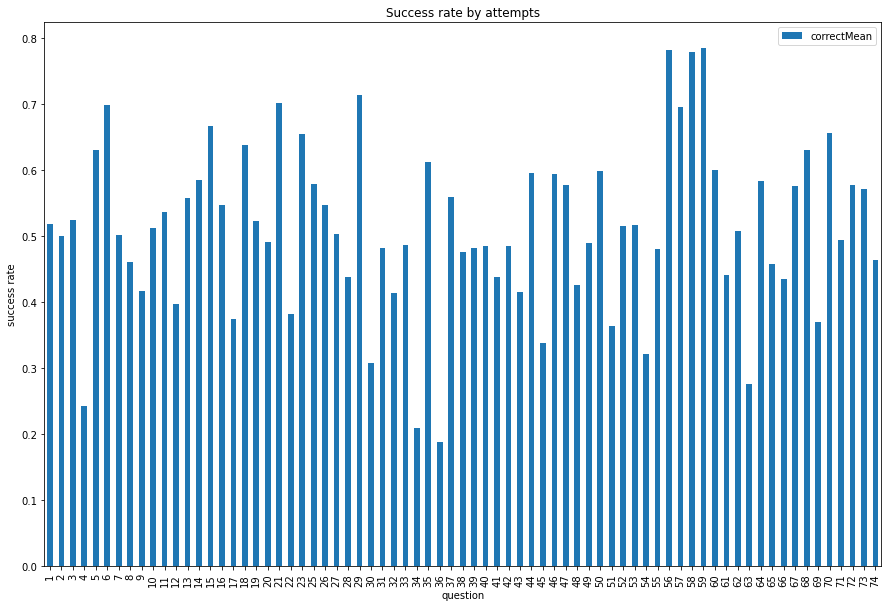

In [159]:
ax = plt.gca()

stats_df.plot(kind='bar', x='item', y='correctMean', title='Success rate by attempts', figsize=(15, 10), ax=ax)

ax.set_ylabel('success rate')
ax.set_xlabel('question')
plt.show()

### Response time
Minimum, average and maximum response time for each question.

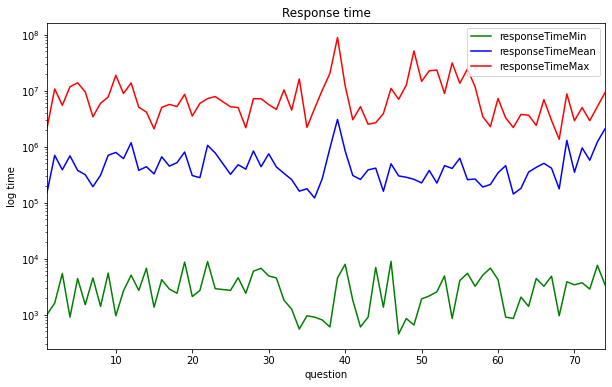

In [87]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='responseTimeMin', color='green', logy=True, figsize=(10, 6),
              title="Response time", ax=ax) 
stats_df.plot(kind='line', x='item', y='responseTimeMean', color='blue', logy=True, ax=ax)
stats_df.plot(kind='line', x='item', y='responseTimeMax', color='red', logy=True, ax=ax)

ax.set_ylabel('log time')
ax.set_xlabel('question')
plt.show()

### Code length in lines
Lowest, average and highest number of lines for each question.

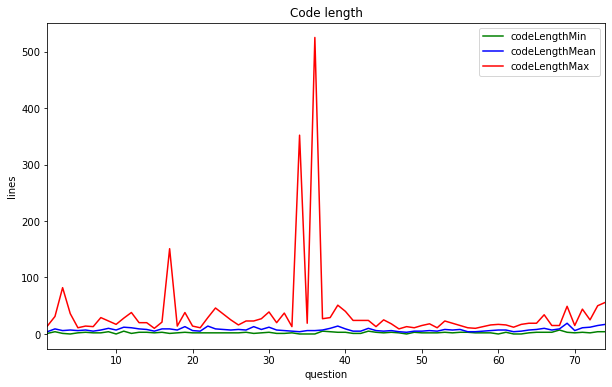

In [88]:
ax = plt.gca()

stats_df.plot(kind='line', x='item', y='codeLengthMin', color='green', figsize=(10, 6), title="Code length", ax=ax) 
stats_df.plot(kind='line', x='item', y='codeLengthMean', color='blue', ax=ax)
stats_df.plot(kind='line', x='item', y='codeLengthMax', color='red', ax=ax)

ax.set_ylabel('lines')
ax.set_xlabel('question')
plt.show()

# PHASE 2

## Difficulty based on success rate
I picked two tasks for each difficulty level.

Easy: 56, 58

Medium: 11, 16

Hard: 30, 45

In [135]:
import ast
import pycode_similar
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA()

def decode_ast(solution):
    try:
        ast.parse(solution)
        return True
    except Exception:
        return False

### What happens here:

Extract few features about each record in task.

Use PCA on these features.

Plot top 2 PCA components in scatter plot.

The colour in plots represents the 'correct' column in the dataframe - whether the answer was correct or not. Yellow points are correct answers, dark point are incorrect answers.

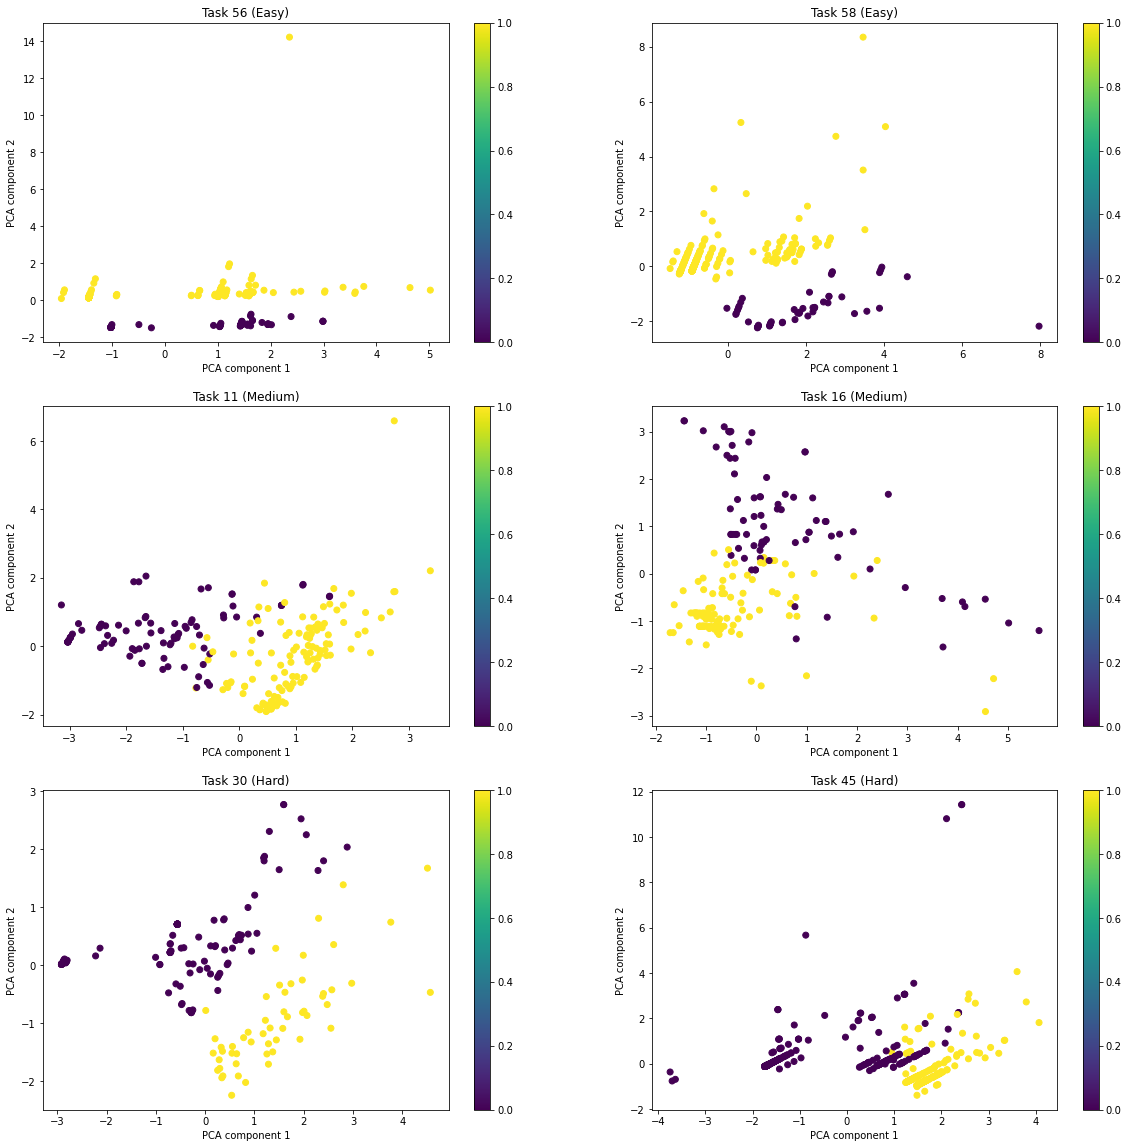

In [156]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for item, dif, plt_row, plt_col in zip([56, 58, 11, 16, 30, 45],
                                       ["Easy", "Easy", "Medium", "Medium", "Hard", "Hard"],
                                       [0, 0, 1, 1, 2, 2],
                                       [0, 1, 0, 1, 0, 1]):
    task_df = log_df[log_df['item'] == item]
    solution = questions_df.at[item, 'solution'][2:-2].split(',')[1].replace('"', '')
    solution = decode_program(solution)
    
    # Find ast-parsable solutions
    parsed = task_df.code.apply(decode_ast)
    # Compute similarity to solution code
    similarities = pycode_similar.detect([solution, *task_df.code[parsed].values])
    sim_perc = np.array([x[1][0].plagiarism_percent for x in similarities])
    
    # Pick only ast-parsable solutions
    task_df_parsed = pd.DataFrame(task_df[parsed])
    task_df_parsed["sim_perc"] = [x[1][0].plagiarism_percent for x in similarities]
    
    # Compute answer's ast length (abstract syntax tree)
    ast_len = []
    for x in similarities:
        if x[1][0].info_candidate is not None:
            ast_len.append(len(x[1][0].info_candidate.func_ast_lines))
        else:
            ast_len.append(0)
            
    # Drop unnecessary columns
    task_df_parsed['ast_len'] = ast_len
    task_df_parsed = task_df_parsed.drop(['id', 'item', 'user', 'time', 'answer', 'code', 'moves'],
                                         axis=1)
    
    # Scale the columns and perform pca
    pca_components = pca.fit_transform(scaler.fit_transform(task_df_parsed[[x for x in task_df_parsed.columns]]))
    
    ax = axes[plt_row, plt_col]
    im = ax.scatter(*pca_components.T[:2], c=task_df_parsed.correct)
    ax.set_title("Task {} ({})".format(item, dif))
    ax.set_ylabel('PCA component 2')
    ax.set_xlabel('PCA component 1')
    fig.colorbar(im, ax=ax)

plt.show()

Plots show that easy tasks have more easily distinguishable correct and incorrect answers, based on two top PCA components. The medium and hard tasks have these two groups overlap eachother a little. This probably means that there were some rather simple/easy mistakes (maybe typoos) in the incorrect solutions that required simple correction to be correct.

Task 30 (hard), however, doesn't overlap almost at all, which is a little surprising. It may be caused by unclear definition of task being hard. For example, tasks 34 and 4 have both low success rates (20 and 24 %), but the amount of answers logged for task 34 is about 20 times higher than for the task 4. (Check out the dataframe in section 'Statistics' above for more detailed informations)